# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

import shap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from os.path import join
import json
import datetime

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

## Examples for the paper

In [16]:
# Example usage:
data1 = np.array([
    [8, 2, 6, 5, 4, 3, 7, 1],
    [5, 8, 3, 6, 7, 4, 1, 2],
    [1, 6, 8, 7, 2, 5, 4, 3],
    [7, 4, 3, 2, 8, 1, 6, 5],
    [4, 6, 2, 3, 1, 7, 5, 8],
])

data2 = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8],
    [1, 2, 3, 4, 5, 6, 8, 7],
    [1, 2, 3, 4, 6, 5, 8, 8],
    [2, 1, 4, 3, 5, 6, 7, 8],
    [1, 3, 2, 4, 5, 6, 7, 8],
])


shap_values = np.array([[0.13, 0.08, 0.07, 0.05, 0.03, -0.03, -0.04, -0.05]])

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_dual_heatmaps(data1, data2):
    """
    Plots two heatmaps side by side for the given datasets.

    Parameters:
    - data1: numpy array for the first heatmap.
    - data2: numpy array for the second heatmap.
    """
    # Define row and column names based on the shape of data1 (assuming both datasets have the same shape)
    rows = [f'Iteration {i+1}' for i in range(data1.shape[0])]
    columns = [f'Feature {i+1}' for i in range(data1.shape[1])]

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Set up a subplot grid that has 1 row and 2 columns

    # Plotting the first heatmap
    sns.heatmap(data1, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", cbar=False, xticklabels=columns, yticklabels=rows, ax=axs[0])
    axs[0].set_title("Anomaly Feature Rank at Each Iteration")
    axs[0].set_xlabel("Features")
    axs[0].set_ylabel("Iterations")

    # Plotting the second heatmap
    sns.heatmap(data2, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", cbar=False, xticklabels=columns, yticklabels=rows, ax=axs[1])
    axs[1].set_title("Anomaly Feature Rank at Each Iteration")
    axs[1].set_xlabel("Features")
    axs[1].set_ylabel("Iterations")

    plt.tight_layout()  # Adjust layout to fit row and column labels
    plt.show()


In [18]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def generate_and_combine_shap_plots(data1, shap_values, label):
    # Tus valores de SHAP y valores esperados
    expected_values = [0.35, 0.36, 0.37, 0.34, 0.33]

    # Generación de nombres de características a partir de data1
    feature_names = [[f'Feature {feature}' for feature in row] for row in data1]

    plot_paths = []

    for i, (expected_value, feature_names_set) in enumerate(zip(expected_values, feature_names), start=1):
        plt.figure()
        plot_path = f'../shap_plot_{label}_{i}.png'  # Asegúrate de usar una ruta accesible
        # Intenta ajustar aquí para menos espacio en blanco, aunque puede tener un efecto limitado
        shap.force_plot(expected_value, shap_values[0], feature_names_set, show=False, matplotlib=True).savefig(plot_path, bbox_inches='tight')
        plt.close()
        plot_paths.append(plot_path)

    # Combinación de todas las imágenes guardadas en una sola
    images = [Image.open(x) for x in plot_paths]
    widths, heights = zip(*(i.size for i in images))

    total_height = sum(heights)
    max_width = max(widths)

    combined_image = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for im in images:
        combined_image.paste(im, (0, y_offset))
        y_offset += im.size[1]

    combined_image_path = f'../combined_shap_plots_{label}.png'
    combined_image.save(combined_image_path)

    # Eliminación de los archivos de trama individuales
    for plot_path in plot_paths:
        os.remove(plot_path)

    # Devolución de la imagen combinada
    return Image.open(combined_image_path)


In [19]:
from PIL import Image, ImageDraw, ImageFont

def combine_images_with_titles(data1, data2, shap_values, title_left, title_right, font_size=20, gap=10):
    img_left = generate_and_combine_shap_plots(data1, shap_values, 'data1')  # Assuming this returns an Image object
    img_right = generate_and_combine_shap_plots(data2, shap_values, 'data2')  # Assuming this returns an Image object
    
    # Calculate dimensions for the new image
    max_height = max(img_left.height, img_right.height)
    # Adjust total_width to include a gap if desired
    total_width = img_left.width + img_right.width - gap

    # Adjusting font settings
    font_name = "Helvetica.ttc"  # Helvetica is usually available on macOS
    font_path = f"/System/Library/Fonts/{font_name}"
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print("Fallback to default font")
        font = ImageFont.load_default()

    # Measure text to determine additional height needed
    draw = ImageDraw.Draw(img_left)  # Dummy draw object to measure text size
    text_height_left = draw.textsize(title_left, font=font)[1]
    text_height_right = draw.textsize(title_right, font=font)[1]
    additional_height = max(text_height_left, text_height_right) + 10  # Add a little padding

    # Create a new image with adjusted height for titles
    new_img = Image.new('RGB', (total_width, max_height + additional_height), 'white')

    # Paste the original images into the new image at adjusted positions
    # Adjust the position of the right image to account for the desired gap
    new_img.paste(img_left, (0, additional_height))
    # Calculate the position for the right image to include the gap
    right_img_x_position = img_left.width - gap
    new_img.paste(img_right, (right_img_x_position, additional_height))

    # Draw the titles in the new adjusted positions
    draw = ImageDraw.Draw(new_img)
    draw.text(((img_left.width - draw.textsize(title_left, font=font)[0]) // 2, 0), title_left, fill="black", font=font)
    draw.text(((total_width + right_img_x_position - draw.textsize(title_right, font=font)[0]) // 2, 0), title_right, fill="black", font=font)

    # Save or display the combined image
    new_img_path = '../shap_example.png'  # Adjust as necessary
    new_img.save(new_img_path)

    return new_img_path


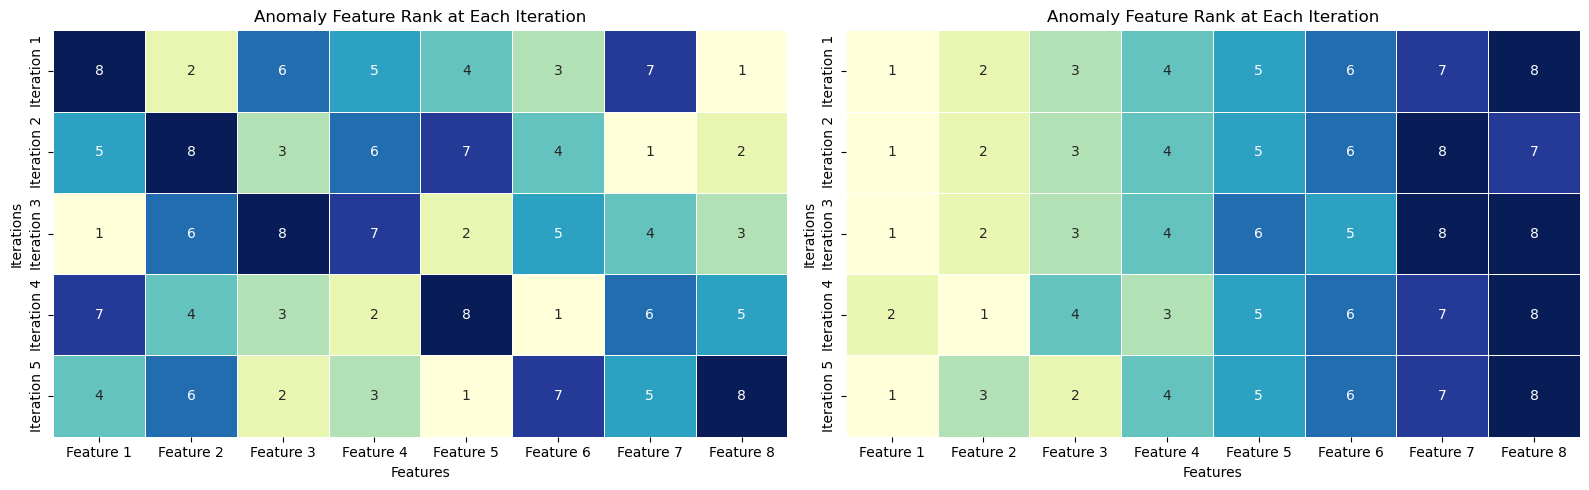

In [20]:
plot_dual_heatmaps(data1, data2)

In [21]:
# Example usage
title_left = 'Local-Interpretability at Each Iteration'
title_right = 'Local-Interpretability at Each Iteration'
combined_image_path = combine_images_with_titles(data1, data2, shap_values, title_left, title_right, gap=1)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

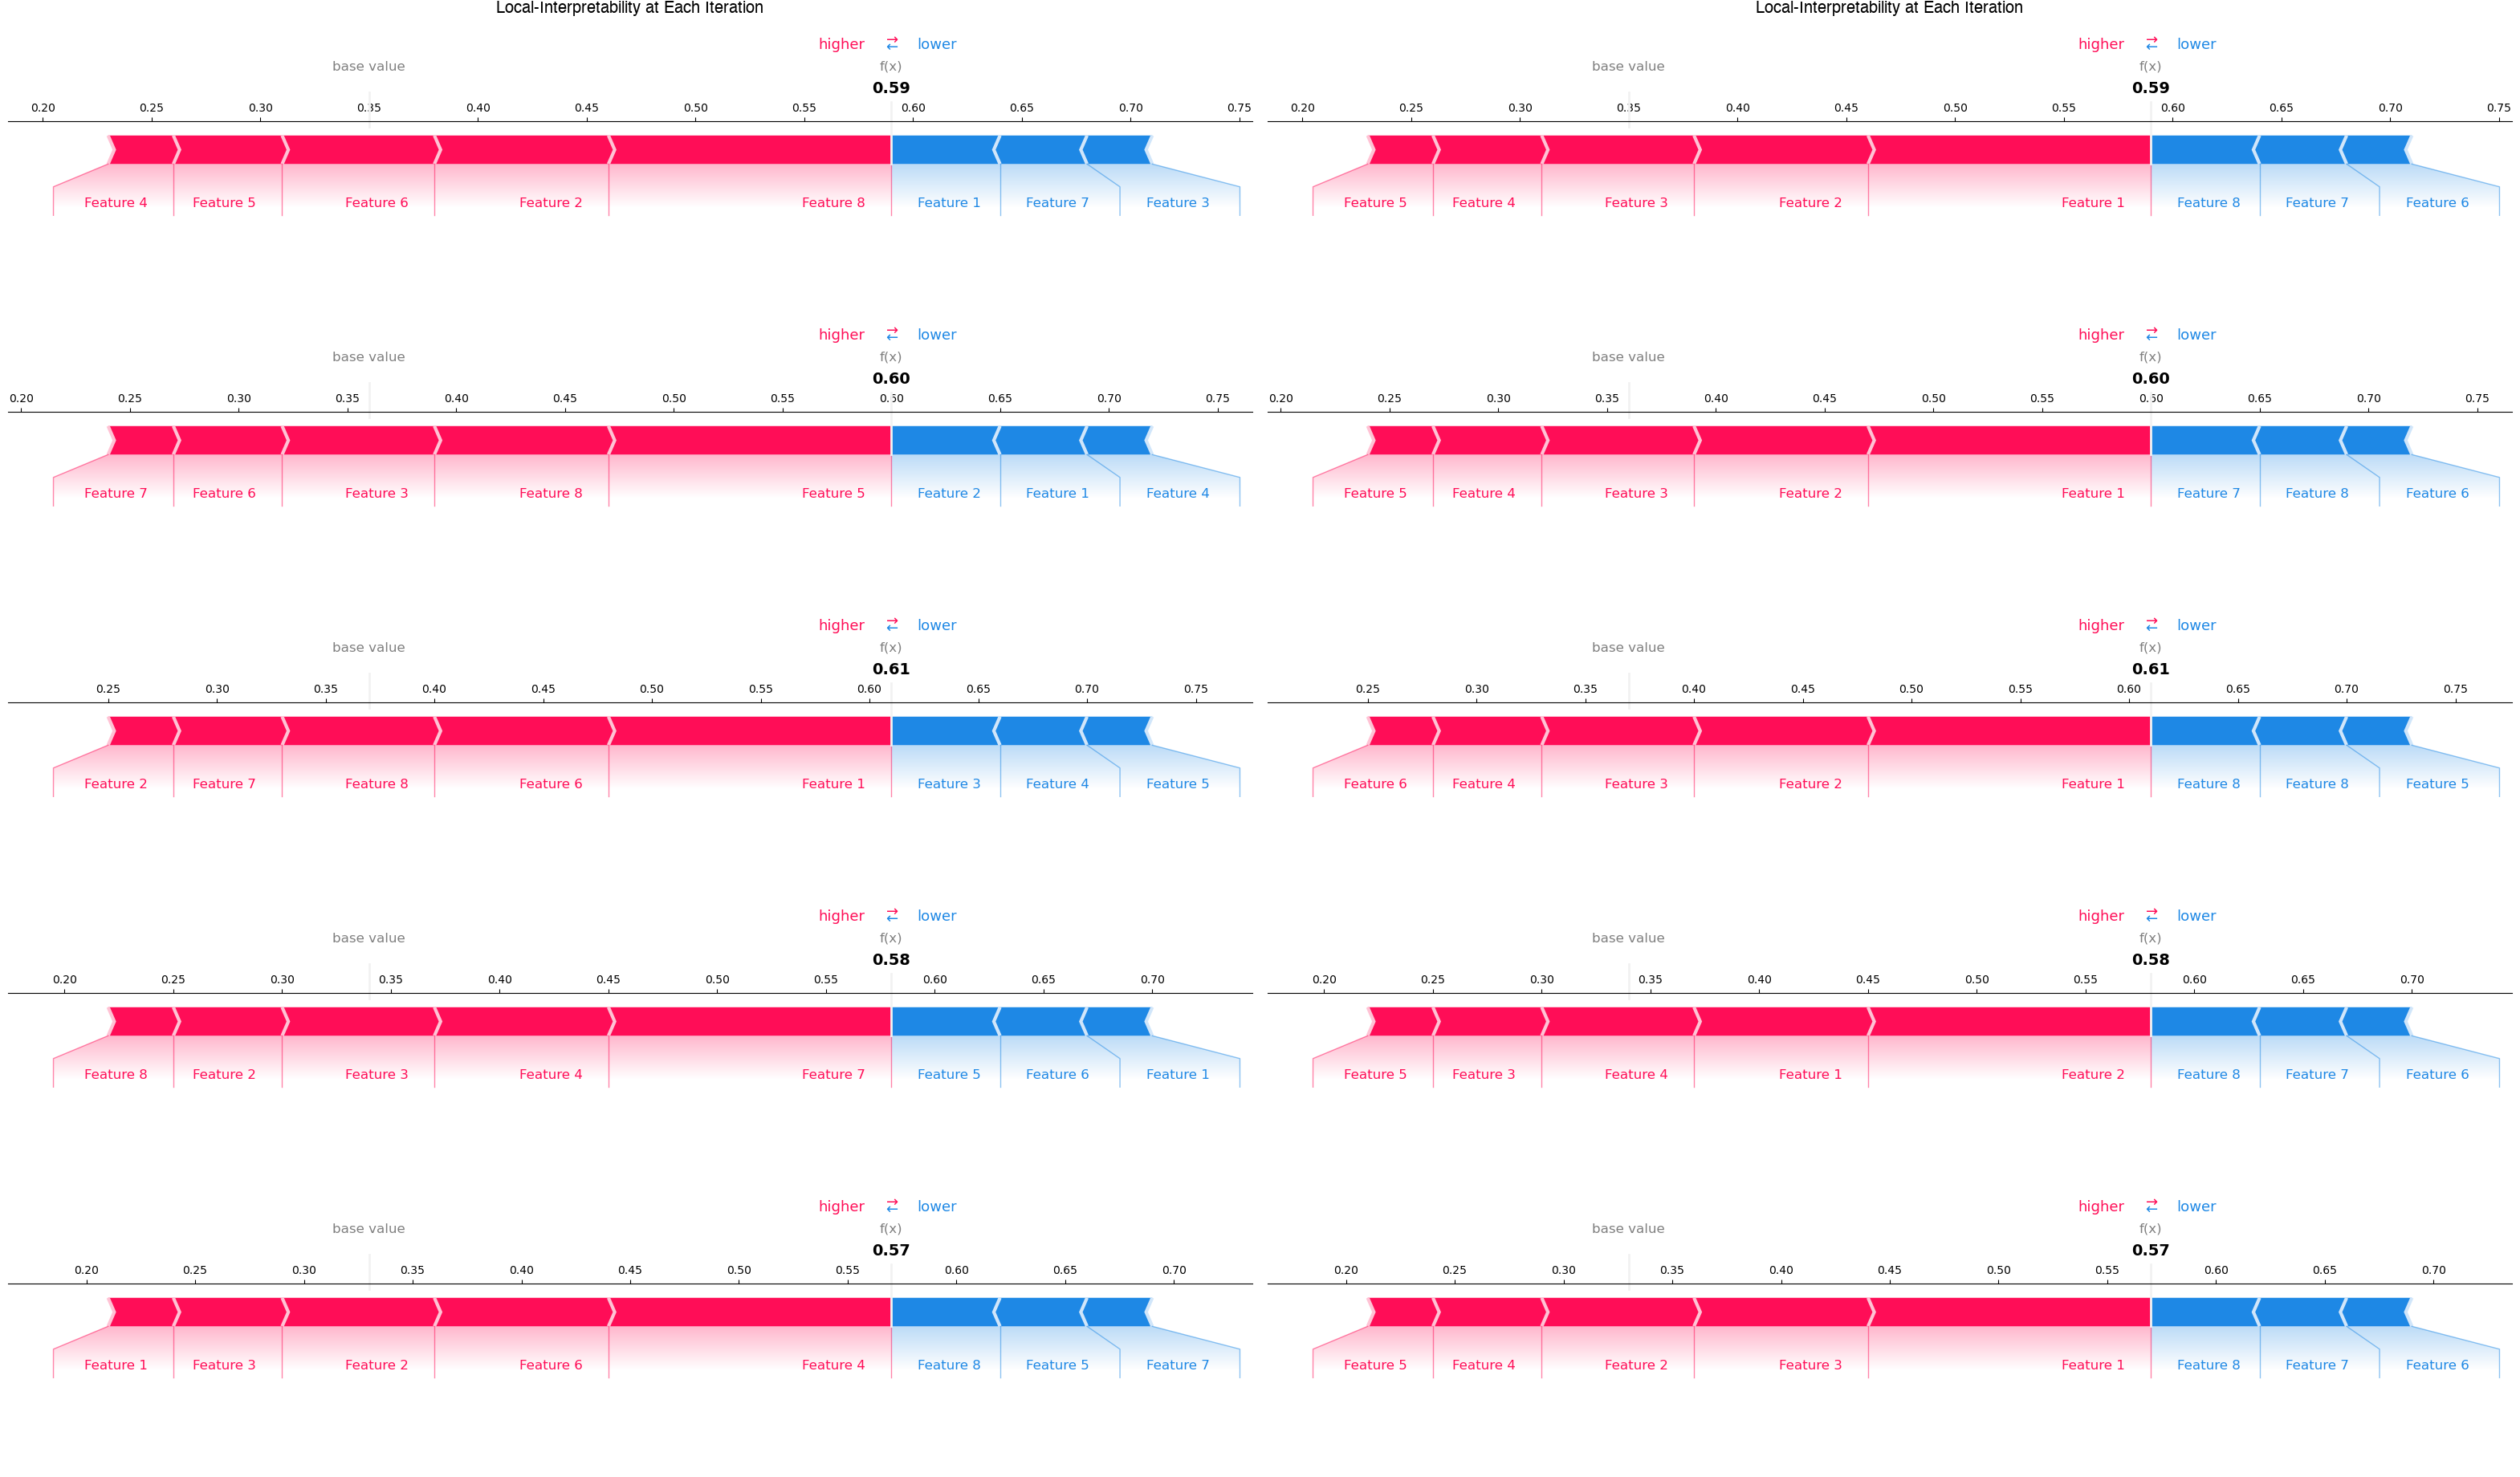

In [22]:
# Save or display the combined image
combined_image_path = '../shap_example.png'  # Adjust as necessary
Image.open(combined_image_path)

In [67]:
# Arrhythmia
dataset_id = 'arrhythmia'

path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_mean'] = df['shap_stab'].apply(lambda x: np.mean(x))
df['shap_variance'] = df['shap_stab'].apply(lambda x: np.var(x))

var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'model_stab', 'shap_stab', 'shap_q2', 'shap_mean', 'shap_variance']
df = df[var]
df = df.sort_values(by=['n_estimators', 'n_feats'], ascending=[True, False])
df = df[df.max_feats == df.n_feats]

df['rank'] = df.groupby('n_estimators').cumcount() + 1

df0 = df[df['rank']==1]
df1 = df[df['rank']==2]
df2 = df[df['rank']==4]
df3 = df[df['rank']==6]
df4 = df[df['rank']==8]
df5 = df[df['rank']==10]

df0 = df0.explode('shap_stab')
df1 = df1.explode('shap_stab')
df2 = df2.explode('shap_stab')
df3 = df3.explode('shap_stab')
df4 = df4.explode('shap_stab')
df5 = df5.explode('shap_stab')

df0['shap_stab'] = pd.to_numeric(df0['shap_stab'])
df1['shap_stab'] = pd.to_numeric(df1['shap_stab'])
df2['shap_stab'] = pd.to_numeric(df2['shap_stab'])
df3['shap_stab'] = pd.to_numeric(df3['shap_stab'])
df4['shap_stab'] = pd.to_numeric(df4['shap_stab'])
df5['shap_stab'] = pd.to_numeric(df5['shap_stab'])

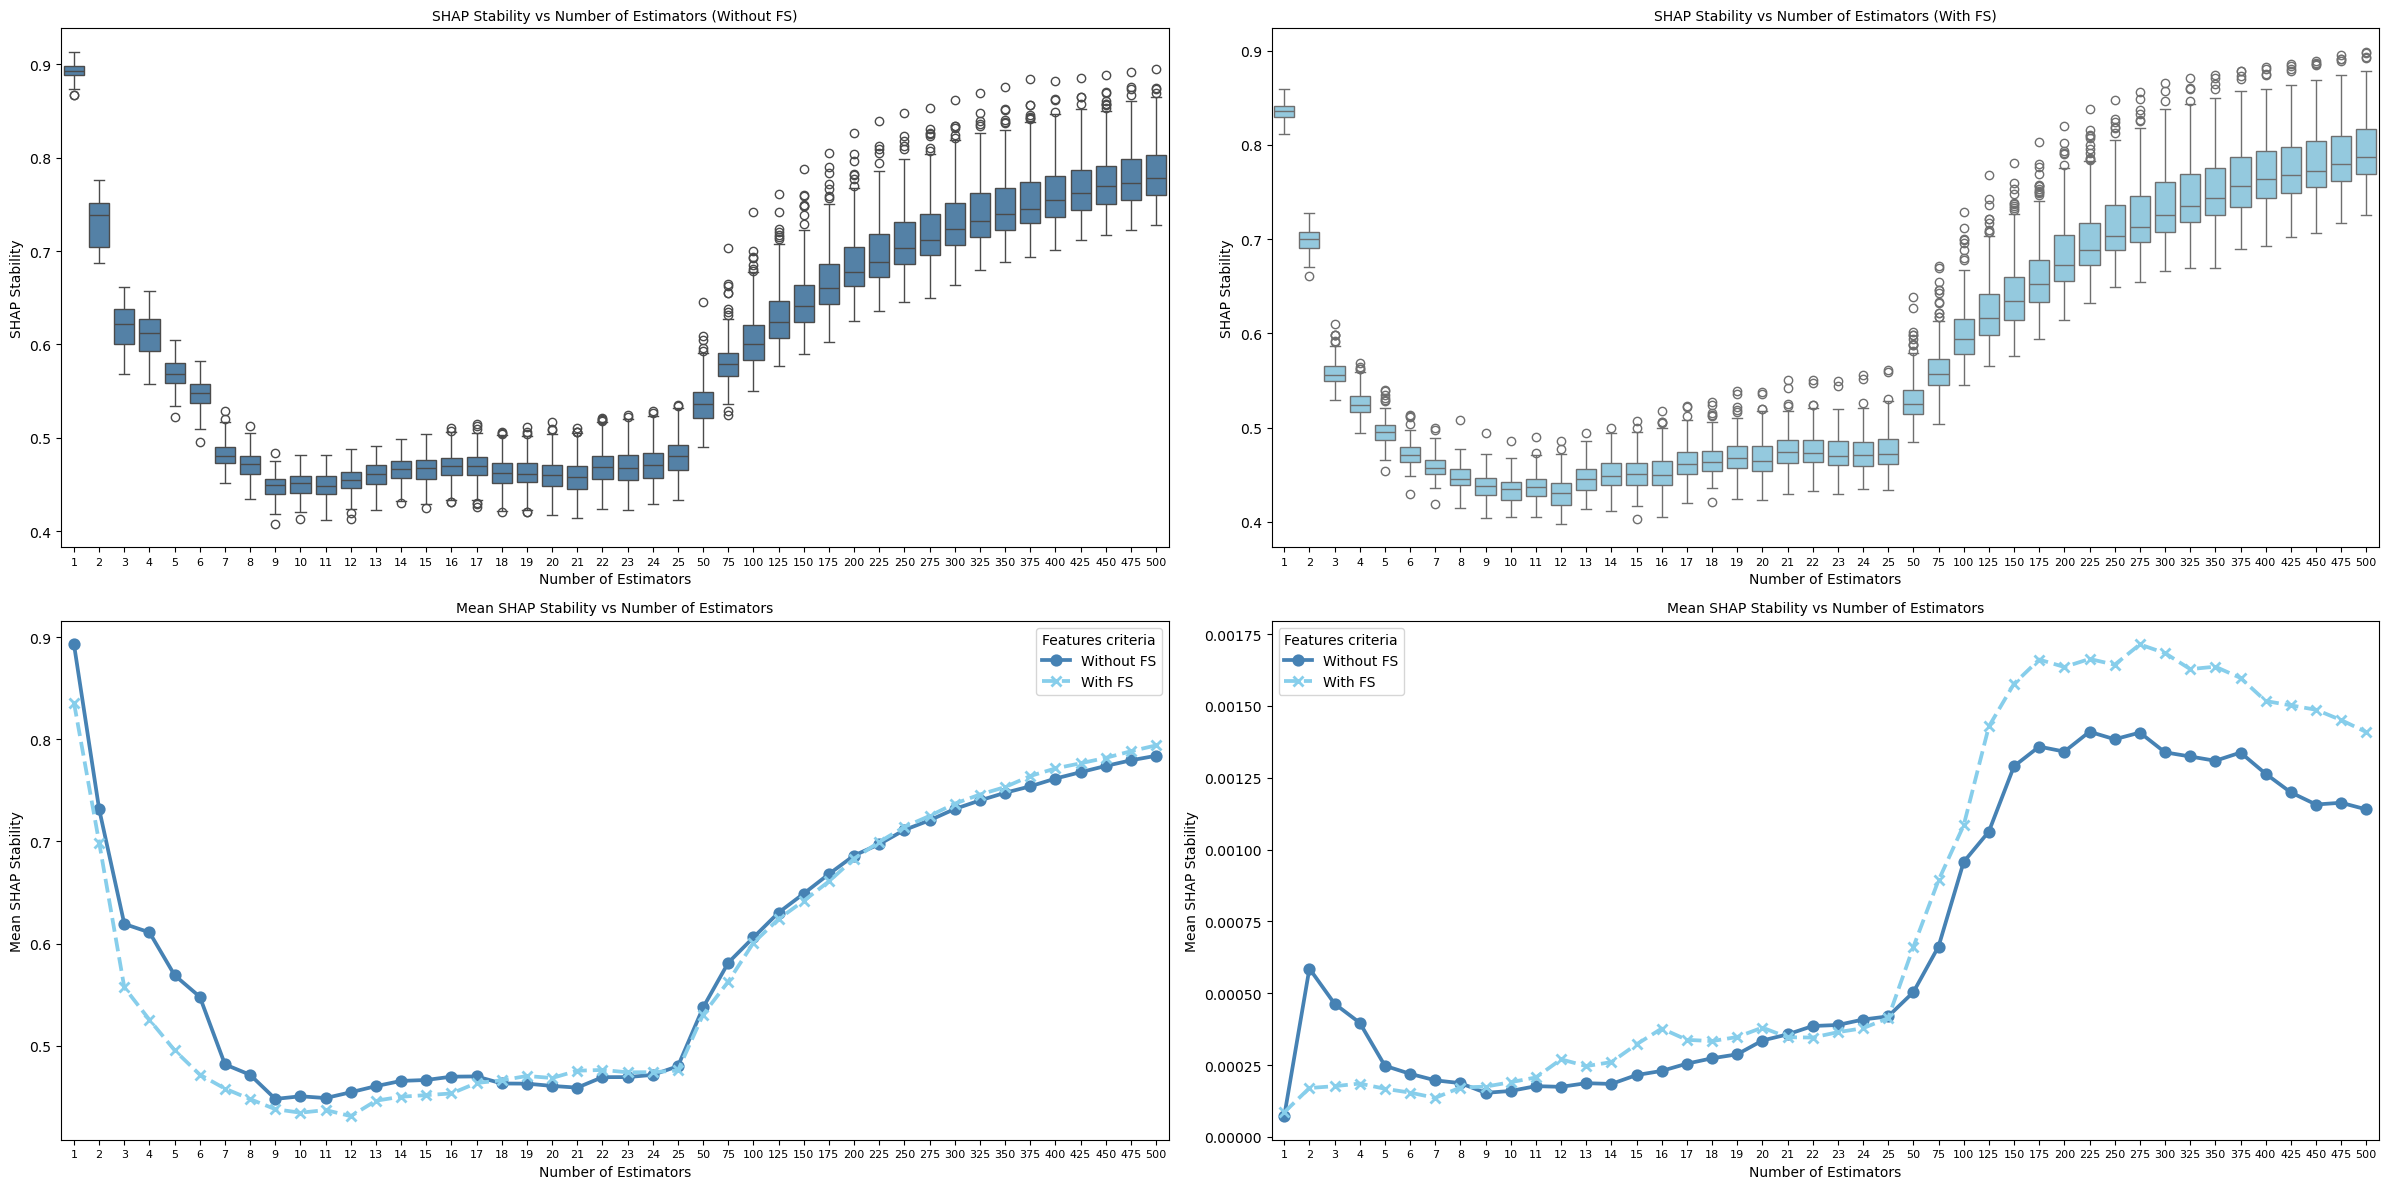

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_exploded_without_fs and df_exploded_with_fs are your dataframes
# Prepare your dataframes here

fontsize = 8 # numbers
# Start of the plotting code
plt.figure(figsize=(24, 12))  # Overall figure size to accommodate the layout

# First plot (first row, first column)
plt.subplot(2, 2, 1)  # The figure has 2 rows and 2 columns, this plot is in the 1st position
sns.boxplot(data=df_exploded_without_fs, x='n_estimators', y='shap_stab', color='steelblue')
plt.xticks(fontsize=fontsize)  # Adjust the font size for consistency
plt.title('SHAP Stability vs Number of Estimators (Without FS)', fontsize=10)
plt.xlabel('Number of Estimators', fontsize=10)
plt.ylabel('SHAP Stability', fontsize=10)

# Second plot (first row, second column)
plt.subplot(2, 2, 2)  # This plot is in the 2nd position
sns.boxplot(data=df_exploded_with_fs, x='n_estimators', y='shap_stab', color='skyblue')
plt.xticks(fontsize=fontsize)
plt.title('SHAP Stability vs Number of Estimators (With FS)', fontsize=10)
plt.xlabel('Number of Estimators', fontsize=10)
plt.ylabel('SHAP Stability', fontsize=10)

# Third plot (second row, spanning first and second column)
plt.subplot(2, 2, 3)  # This plot spans across the full width of the second row
sns.pointplot(data=df0, x='n_estimators', y='shap_mean', color='steelblue', markers='o', linestyles='-', ci=None, label='Without FS')
sns.pointplot(data=df1, x='n_estimators', y='shap_mean', color='skyblue', markers='x', linestyles='--', ci=None, label='With FS')
plt.xticks(fontsize=fontsize)
plt.title('Mean SHAP Stability vs Number of Estimators', fontsize=10)
plt.xlabel('Number of Estimators', fontsize=10)
plt.ylabel('Mean SHAP Stability', fontsize=10)
plt.legend(title='Features criteria', fontsize=10)

# Third plot (second row, spanning first and second column)
plt.subplot(2, 2, 4)  # This plot spans across the full width of the second row
sns.pointplot(data=df0, x='n_estimators', y='shap_variance', color='steelblue', markers='o', linestyles='-', ci=None, label='Without FS')
sns.pointplot(data=df1, x='n_estimators', y='shap_variance', color='skyblue', markers='x', linestyles='--', ci=None, label='With FS')
plt.xticks(fontsize=fontsize)
plt.title('Mean SHAP Stability vs Number of Estimators', fontsize=10)
plt.xlabel('Number of Estimators', fontsize=10)
plt.ylabel('Mean SHAP Stability', fontsize=10)
plt.legend(title='Features criteria', fontsize=10)

plt.tight_layout()  # Adjust layout
plt.show()


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_shap_stability(dataframes, titles, colors):
    """
    Plots SHAP stability boxplots for given dataframes.

    Parameters:
    - dataframes: List of pandas DataFrames to plot.
    - titles: List of titles for each subplot.
    - colors: List of colors for each boxplot.
    """
    if not (len(dataframes) == len(titles) == len(colors)):
        raise ValueError("All input lists must have the same length")
    
    plt.figure(figsize=(24, 18))  # Overall figure size

    # Adjustments for consistent appearance
    fontsize = 7
    n_cols = 2
    n_rows = len(dataframes) // n_cols + (len(dataframes) % n_cols > 0)

    for i, (df, title, color) in enumerate(zip(dataframes, titles, colors), start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(data=df, x='n_estimators', y='shap_stab', color=color)
        plt.xticks(fontsize=fontsize)
        plt.title(title, fontsize=fontsize)
        plt.xlabel('Number of Estimators', fontsize=fontsize)
        plt.ylabel('SHAP Stability', fontsize=fontsize)

    plt.tight_layout()  # Adjust layout
    plt.show()

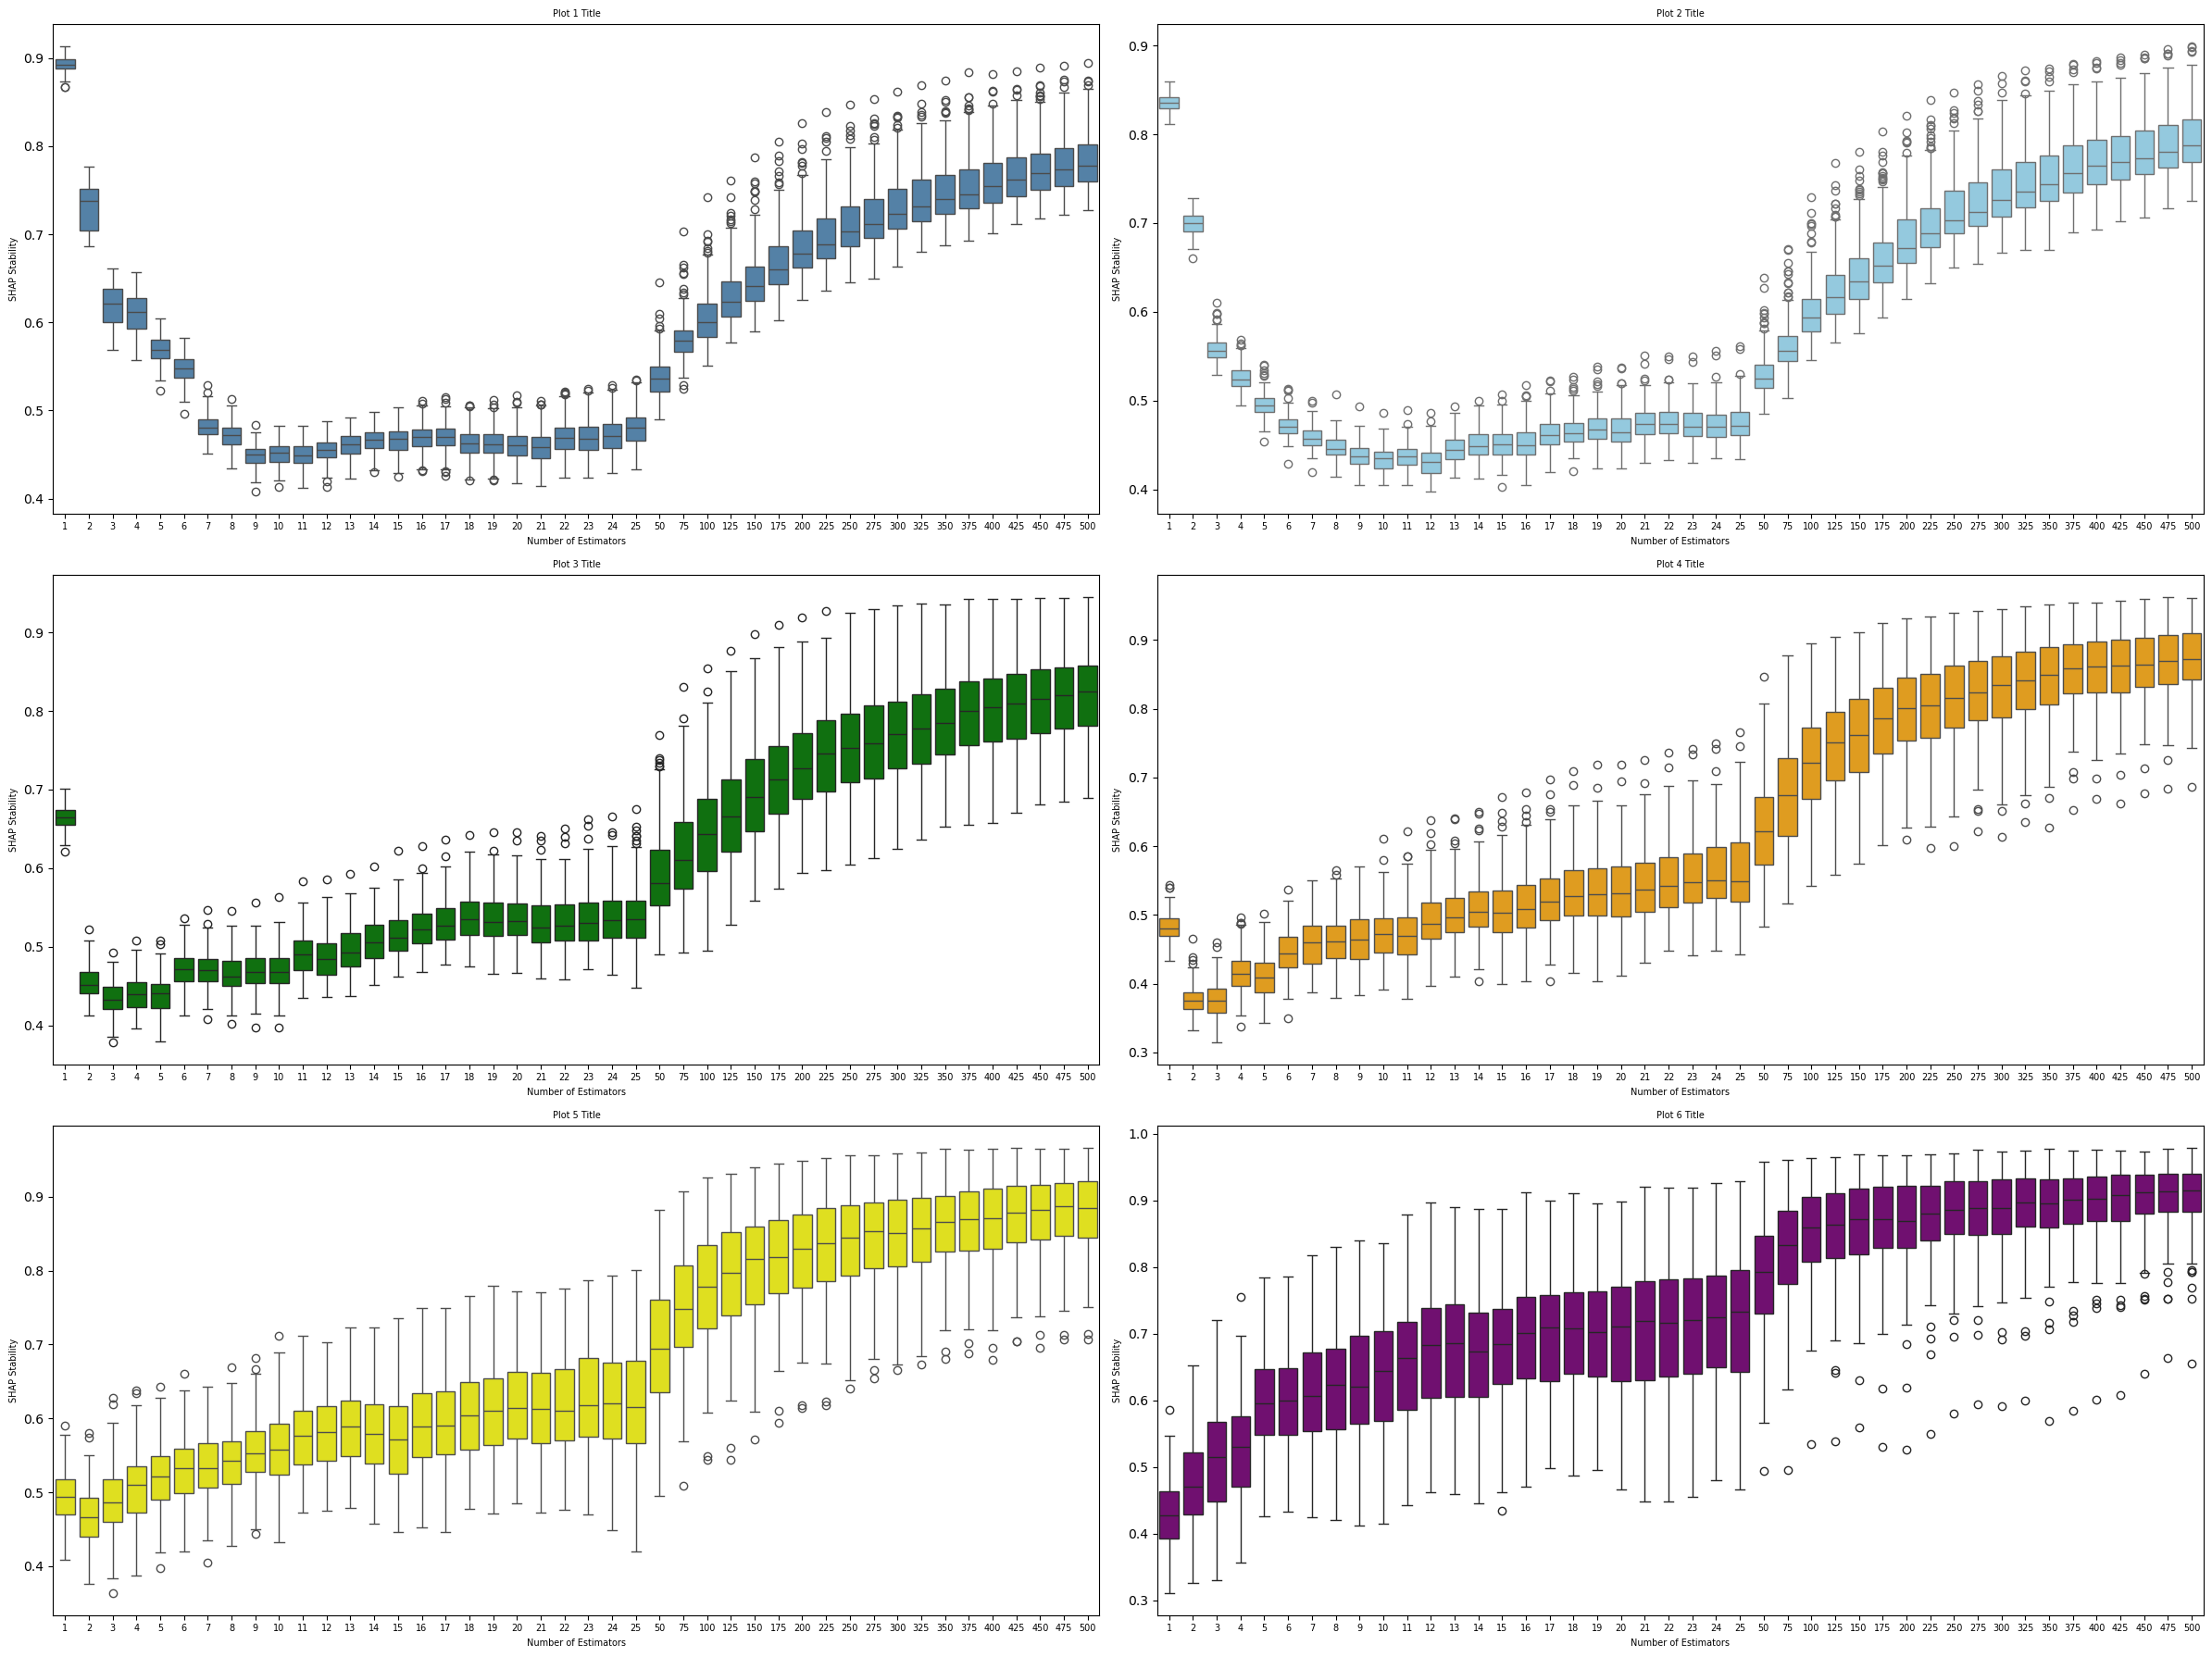

In [72]:
# Example usage:
# Assuming df0, df1, df2, df3, df4, df5 are your dataframes
dataframes = [df0, df1, df2, df3, df4, df5]
titles = ['Plot 1 Title', 'Plot 2 Title', 'Plot 3 Title', 'Plot 4 Title', 'Plot 5 Title', 'Plot 6 Title']
colors = ['steelblue', 'skyblue', 'green', 'orange', 'yellow', 'purple']

plot_shap_stability(dataframes, titles, colors)

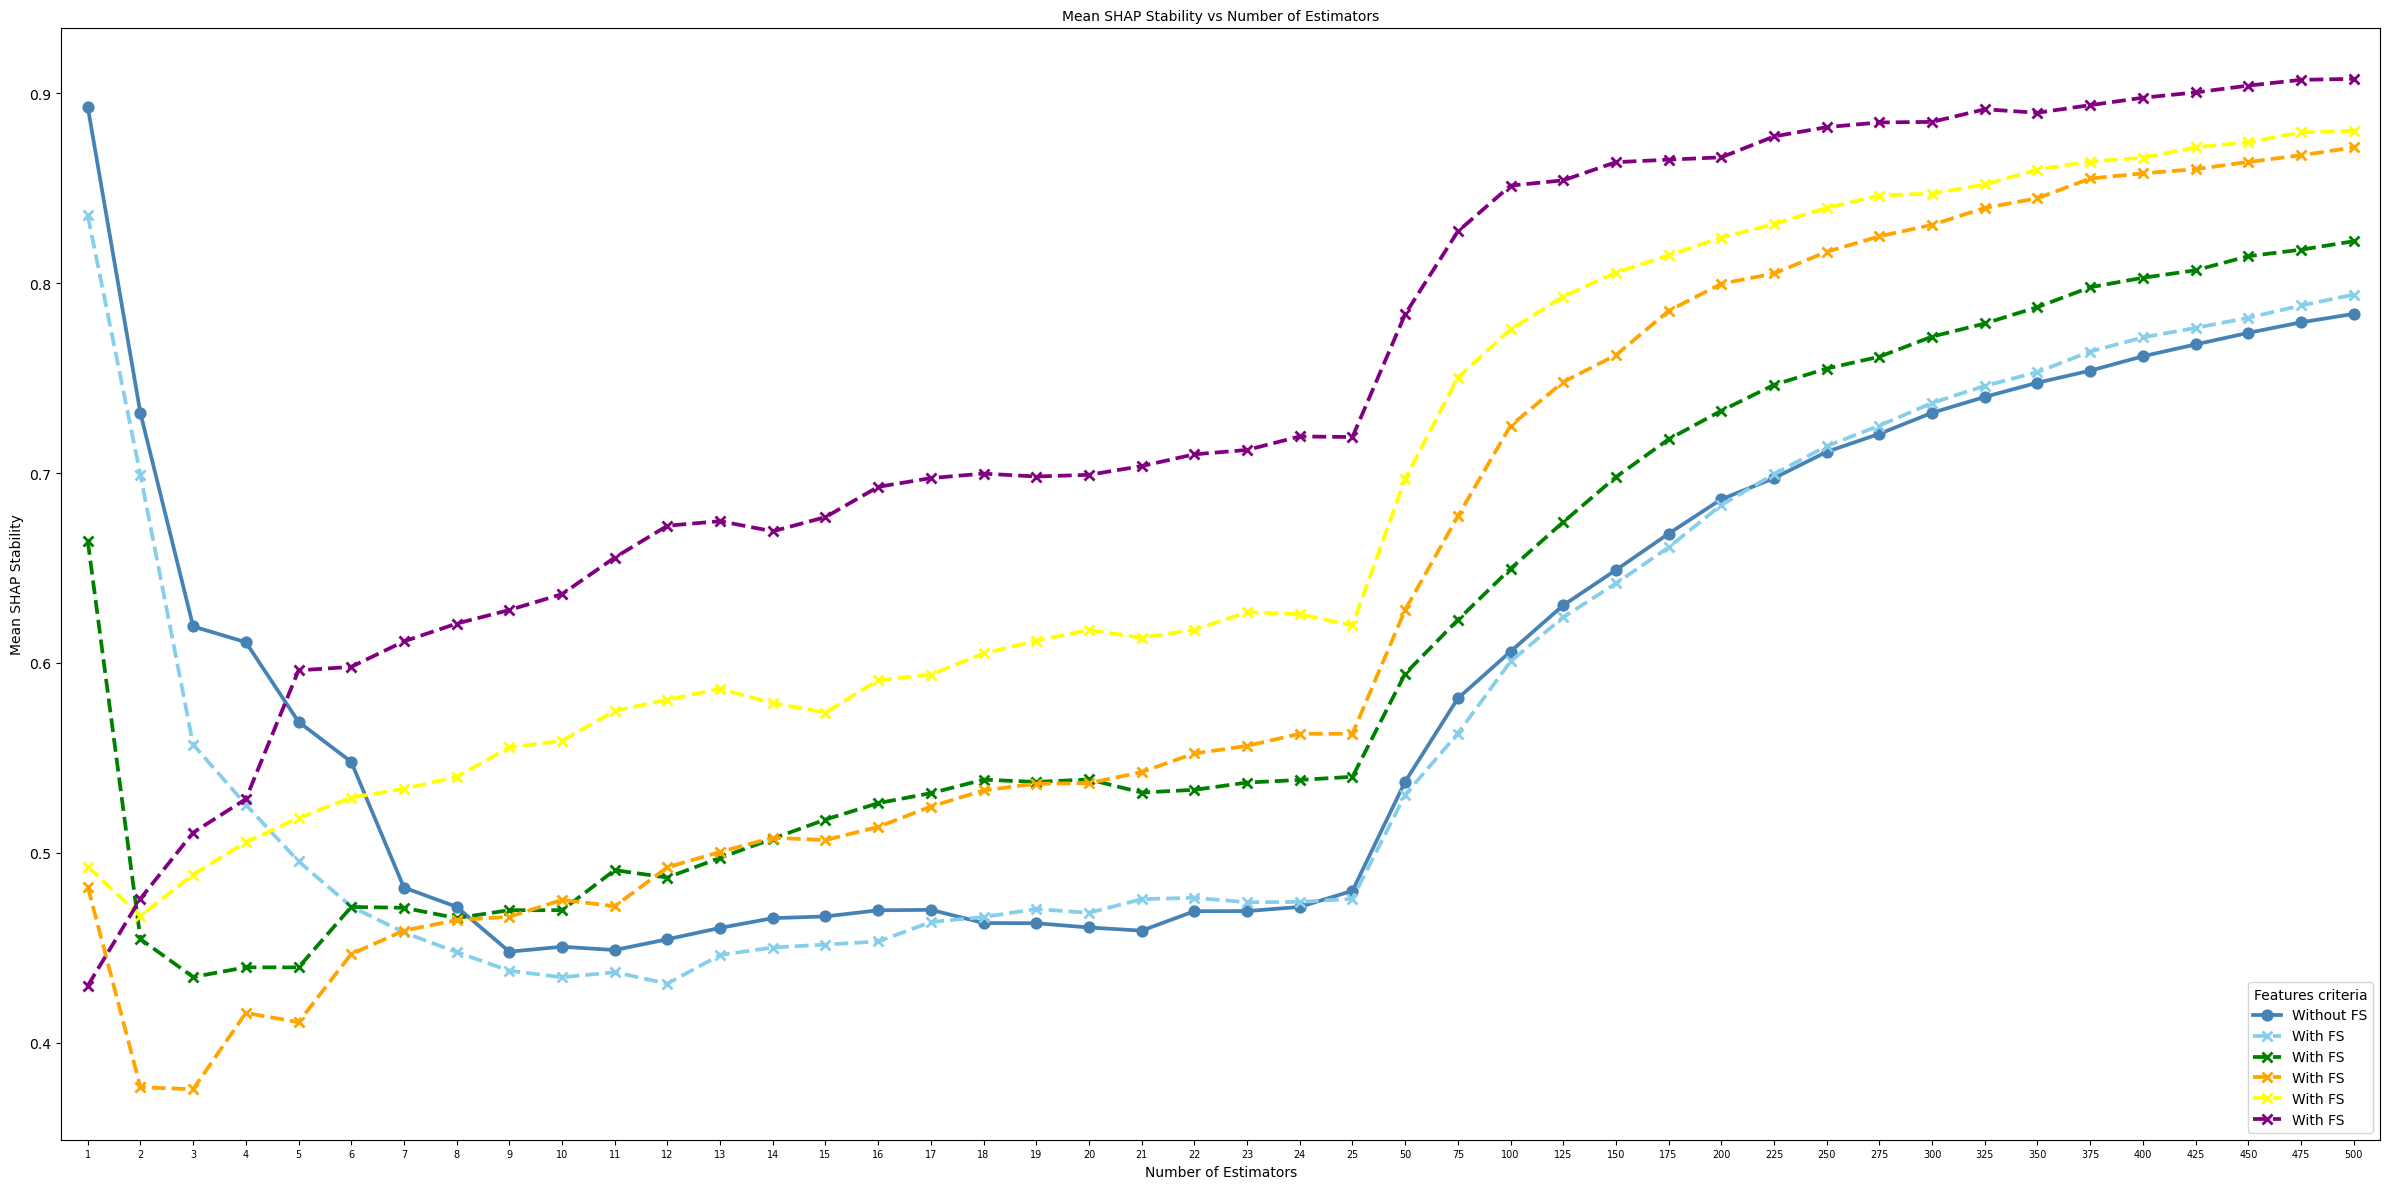

In [70]:
# Start of the plotting code
plt.figure(figsize=(24, 12))  # Overall figure size to accommodate the layout

# Third plot (second row, spanning first and second column)
plt.subplot(1, 1, 1)  # This plot spans across the full width of the second row
sns.pointplot(data=df0, x='n_estimators', y='shap_mean', color='steelblue', markers='o', linestyles='-', ci=None, label='Without FS')
sns.pointplot(data=df1, x='n_estimators', y='shap_mean', color='skyblue', markers='x', linestyles='--', ci=None, label='With FS')
sns.pointplot(data=df2, x='n_estimators', y='shap_mean', color='green', markers='x', linestyles='--', ci=None, label='With FS')
sns.pointplot(data=df3, x='n_estimators', y='shap_mean', color='orange', markers='x', linestyles='--', ci=None, label='With FS')
sns.pointplot(data=df4, x='n_estimators', y='shap_mean', color='yellow', markers='x', linestyles='--', ci=None, label='With FS')
sns.pointplot(data=df5, x='n_estimators', y='shap_mean', color='purple', markers='x', linestyles='--', ci=None, label='With FS')


plt.xticks(fontsize=fontsize)
plt.title('Mean SHAP Stability vs Number of Estimators', fontsize=10)
plt.xlabel('Number of Estimators', fontsize=10)
plt.ylabel('Mean SHAP Stability', fontsize=10)
plt.legend(title='Features criteria', fontsize=10)

plt.tight_layout()  # Adjust layout
plt.show()